<a href="https://colab.research.google.com/github/JSJeong-me/KOSA_Generate_AI_for_Image/blob/main/140-ControlNet_Canny.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text-to-Image Generation with ControlNet Conditioning

https://huggingface.co/docs/diffusers/v0.14.0/en/api/pipelines/stable_diffusion/controlnet




In [ ]:
!pip install -qq opencv-contrib-python diffusers transformers git+https://github.com/huggingface/accelerate.git

## 1. Canny Edge to Image

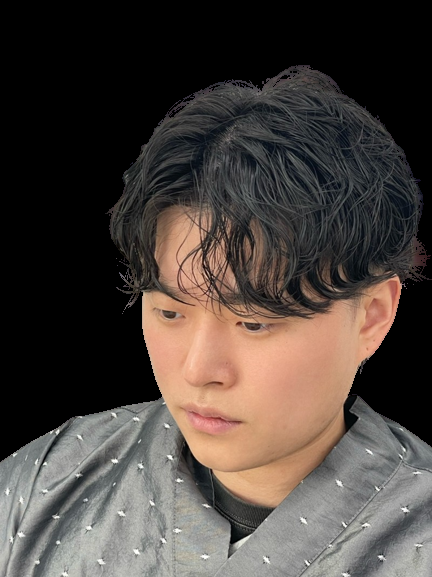

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image("lobe-hippie-perm_-removebg.png")

image

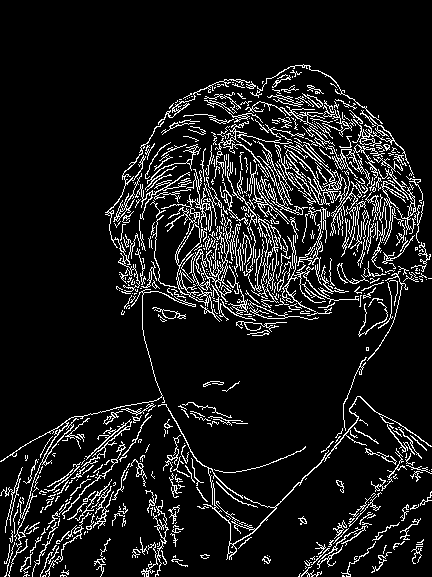

In [ ]:
import cv2
from PIL import Image
import numpy as np

low_threshold = 75
high_threshold = 200

np_image = np.array(image)

canny_image = cv2.Canny(np_image, low_threshold, high_threshold)

canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

canny_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
from diffusers import UniPCMultistepScheduler
import torch

controlnet_model = "lllyasviel/sd-controlnet-canny"
sd_model = "runwayml/stable-diffusion-v1-5"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model, controlnet=controlnet, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

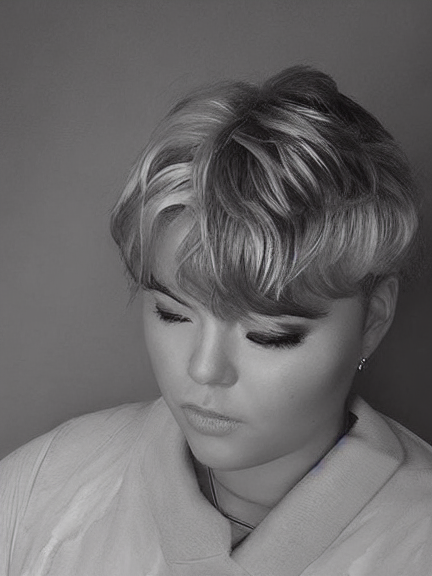

In [ ]:
prompt = "Short hair."
num_steps = 20
seed = 0

out_image = pipe(
    prompt,
    num_inference_steps=num_steps,
    generator=torch.manual_seed(seed),
    image=canny_image
).images[0]

out_image

In [ ]:
Image.fromarray(np.concatenate([image, canny_image, out_image], axis=1))

ValueError: ignored

## 2. Depth to Image

Trained with Midas depth estimation

> [!] You need to restart the kernel.

> [!] 런타임을 다시 시작해야 합니다.

In [ ]:
from transformers import pipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from PIL import Image
import numpy as np
import torch
from diffusers.utils import load_image

depth_estimator = pipeline('depth-estimation')

No model was supplied, defaulted to Intel/dpt-large and revision e93beec (https://huggingface.co/Intel/dpt-large).
Using a pipeline without specifying a model name and revision in production is not recommended.


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
image = load_image("https://i.imgur.com/2V9gTol.jpg")

image

UnidentifiedImageError: ignored

In [ ]:
depth_image = depth_estimator(image)['depth']
depth_image = np.array(depth_image)
depth_image = depth_image[:, :, None]
depth_image = np.concatenate([depth_image, depth_image, depth_image], axis=2)
depth_image = Image.fromarray(depth_image)

depth_image

andite/anything-v4.0

https://huggingface.co/andite/anything-v4.0

In [ ]:
controlnet_model = "fusing/stable-diffusion-v1-5-controlnet-depth"
sd_model = "andite/anything-v4.0"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16,
)

pipe.enable_model_cpu_offload()

In [ ]:
pipe.scheduler.compatibles

In [ ]:
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler, HeunDiscreteScheduler, DDPMScheduler, EulerDiscreteScheduler, KDPM2DiscreteScheduler, EulerAncestralDiscreteScheduler, DEISMultistepScheduler, KDPM2AncestralDiscreteScheduler, UniPCMultistepScheduler, LMSDiscreteScheduler, PNDMScheduler, DPMSolverSinglestepScheduler

pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

In [ ]:
prompt = "scenery, mountain, village, outdoors, sky, clouds"
num_steps = 50
guidance_scale = 14
seed = 1

out_image = pipe(
    prompt,
    num_inference_steps=num_steps,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
    image=depth_image,
).images[0]

out_image

In [ ]:
Image.fromarray(np.concatenate([image.resize(out_image.size), depth_image.resize(out_image.size), out_image], axis=1))

## 3. Pose to Image

Trained with [OpenPose bone](https://github.com/CMU-Perceptual-Computing-Lab/openpose) image

In [ ]:
!pip install -qq controlnet_aux

In [ ]:
from PIL import Image
import numpy as np
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image

openpose = OpenposeDetector.from_pretrained('lllyasviel/ControlNet')

In [ ]:
image = load_image("https://i.imgur.com/uJpMDyu.jpg")

image

In [ ]:
pose_image = openpose(image)

pose_image

Ether Real Mix - ERM

https://civitai.com/models/18207/ether-real-mix-erm

In [ ]:
!git clone -b non-ema --single-branch https://huggingface.co/runwayml/stable-diffusion-v1-5

In [ ]:
!wget https://civitai.com/api/download/models/21558 -O stable-diffusion-v1-5/etherRealMixERM_etherrealmixERMV1.safetensors

In [ ]:
controlnet_model = "fusing/stable-diffusion-v1-5-controlnet-openpose"
sd_model = "/content/stable-diffusion-v1-5"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model,
    controlnet=controlnet,
    safety_checker=None,
    torch_dtype=torch.float16
)

pipe.enable_model_cpu_offload()

In [ ]:
pipe.scheduler.compatibles

In [ ]:
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler, HeunDiscreteScheduler, DDPMScheduler, EulerDiscreteScheduler, KDPM2DiscreteScheduler, EulerAncestralDiscreteScheduler, DEISMultistepScheduler, KDPM2AncestralDiscreteScheduler, UniPCMultistepScheduler, LMSDiscreteScheduler, PNDMScheduler, DPMSolverSinglestepScheduler

pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)

In [ ]:
prompt = "RAW photo, a portrait photo of 50 y.o japanese man in clothes, night tokyo, (high detailed skin:1.2), 8k uhd, dslr, soft lighting, high quality, film grain, Fujifilm XT3"
negative_prompt = "NSFW, (worst quality, low quality:1.3), watermark, signature"
num_steps = 28
guidance_scale = 7
seed = 51251555

out_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_steps,
    guidance_scale=guidance_scale,
    generator=torch.manual_seed(seed),
    image=pose_image,
).images[0]

out_image

In [ ]:
Image.fromarray(np.concatenate([image.resize(out_image.size), pose_image.resize(out_image.size), out_image], axis=1))

## Functionalize

Lykon/DreamShaper

https://huggingface.co/Lykon/DreamShaper

> 사진 출처: https://naver.me/FBDHScMN

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
from diffusers import DDIMScheduler, DPMSolverMultistepScheduler, HeunDiscreteScheduler, DDPMScheduler, EulerDiscreteScheduler, KDPM2DiscreteScheduler, EulerAncestralDiscreteScheduler, DEISMultistepScheduler, KDPM2AncestralDiscreteScheduler, UniPCMultistepScheduler, LMSDiscreteScheduler, PNDMScheduler, DPMSolverSinglestepScheduler
import cv2
from PIL import Image
import numpy as np
from diffusers import DDPMScheduler
import torch
import random, sys

controlnet_model = "lllyasviel/sd-controlnet-canny"
sd_model = "Lykon/DreamShaper"

controlnet = ControlNetModel.from_pretrained(
    controlnet_model,
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    sd_model,
    controlnet=controlnet,
    torch_dtype=torch.float16
)

pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
pipe.enable_model_cpu_offload()

def img2img(img_path, prompt, negative_prompt, num_steps=20, guidance_scale=7, seed=0, low=100, high=200):
    image = load_image(img_path)

    np_image = np.array(image)

    canny_image = cv2.Canny(np_image, low, high)

    canny_image = canny_image[:, :, None]
    canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
    canny_image = Image.fromarray(canny_image)

    out_image = pipe(
        prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=torch.manual_seed(seed),
        image=canny_image
    ).images[0]

    return image, canny_image, out_image

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, school uniform, scarf, gymnasium"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 3467120481370323442

image, canny_image, out_image = img2img("02.png", prompt, negative_prompt, num_steps, guidance_scale, seed)

out_image.save("02_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, black scarf, girl smiling"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 435344686523010981

image, canny_image, out_image = img2img("03.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed)

out_image.save("03_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, 1girl, wearing red dress, bangs"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 9116952701319272770

image, canny_image, out_image = img2img("04.png", prompt, negative_prompt, num_steps, guidance_scale, seed, 20, 30)

out_image.save("04_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, white dress, taking a selfie, rooftop"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 3753874598980160300

image, canny_image, out_image = img2img("05.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed)

out_image.save("05_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, in the car, lady, smiling, 2 hands, night"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 2613502034148708032

image, canny_image, out_image = img2img("06.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed)

out_image.save("06_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, mouth opened, clap"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 8261080970612651612

image, canny_image, out_image = img2img("07.png", prompt, negative_prompt, num_steps, guidance_scale, seed, 40, 50)

out_image.save("07_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a man and a woman, back of a woman's head"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 4181356513335062704

image, canny_image, out_image = img2img("08.png", prompt, negative_prompt, num_steps, guidance_scale, seed, 50, 100)

out_image.save("08_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a man and a woman, game of go, gomoku"
negative_prompt = "lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 2057684270613828998

image, canny_image, out_image = img2img("09.png", prompt, negative_prompt, num_steps, guidance_scale, seed, 50, 100)

out_image.save("09_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, lady, looking at viewer"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 4270593513915871173

image, canny_image, out_image = img2img("10.png", prompt, negative_prompt, num_steps, guidance_scale, seed, 40, 60)

out_image.save("10_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, 2ladies looking each other, angry"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 2110816170898921984

image, canny_image, out_image = img2img("11.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 40, 60)

out_image.save("11_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a man sitting, a lady sitting, tree, autumn, fallen leaves"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 3311352378018201782

image, canny_image, out_image = img2img("12.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 40, 60)

out_image.save("12_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a lady wearing underwear, blurry man"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 981662291656751384

image, canny_image, out_image = img2img("13.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 20, 30)

out_image.save("13_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a girl with backpack, a man down on his knee"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 3465640518011203857

image, canny_image, out_image = img2img("14.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 50, 100)

out_image.save("14_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, 2 young men, in the classroom"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 8739328014465365356

image, canny_image, out_image = img2img("15.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 100, 150)

out_image.save("15_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))

In [ ]:
prompt = "masterpiece, best quality, ultra-detailed, illustration, a man, close mouth, swallow a laugh"
negative_prompt = "NSFW, lowres, ((bad anatomy)), ((bad hands)), text, missing finger, extra digits, fewer digits, blurry, ((mutated hands and fingers)), (poorly drawn face), ((mutation)), ((deformed face)), (ugly), ((bad proportions)), ((extra limbs)), extra face, (double head), (extra head), ((extra feet)), monster, logo, cropped, worst quality, low quality, normal quality, jpeg, humpbacked, long body, long neck, ((jpeg artifacts))"
num_steps = 20
guidance_scale = 7
seed = 6964547109648557242

image, canny_image, out_image = img2img("16.jpg", prompt, negative_prompt, num_steps, guidance_scale, seed, 25, 50)

out_image.save("16_result.png")
Image.fromarray(np.concatenate([image.resize(out_image.size), canny_image.resize(out_image.size), out_image], axis=1))